In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///11-SQLAlchemy_Homework_Instructions_Resources_hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# We can view all of the columns for each class that automap found
inspector = inspect(engine)
col_measurement = inspector.get_columns('measurement')
col_station = inspector.get_columns('station')
print("Measurement Columns")
for c_m in col_measurement:
    #print(c_m)
    print(c_m['name'], c_m["type"])
print("")
print("Station Columns")
for c_s in col_station:
    #print(c_s)
    print(c_s['name'], c_s["type"])


Measurement Columns
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station Columns
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results
# Get last data point in the database
last_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago= dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

datetime.date(2016, 8, 23)

In [13]:
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
rain

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain).set_index("date")
# Sort the dataframe by date
rain_df.sort_values('date' , ascending=True)
rain_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


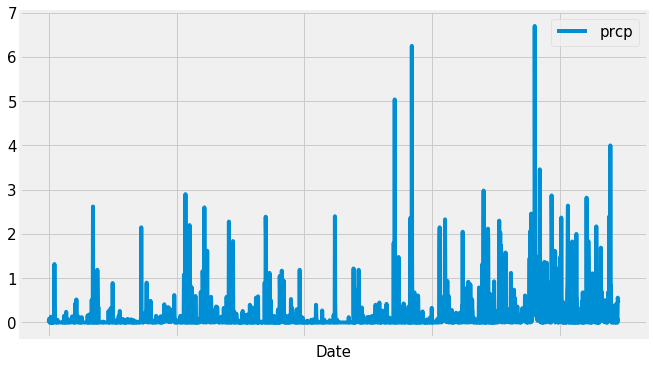

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(figsize=(10, 6), stacked=True, x_compat=True, fontsize = 15)
plt.xlabel('Date',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station).count()
total_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_s= engine.execute('SELECT station, COUNT(*) AS num_of_stations FROM Measurement \
    GROUP BY Measurement.station ORDER BY num_of_stations DESC LIMIT 10').fetchall()
active_df= pd.DataFrame(active_s,columns=['Station', 'Count'])
active_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Station.station == f"{active_df['Station'][0]}").first()

(53.0, 87.0, 73.09795396419437)

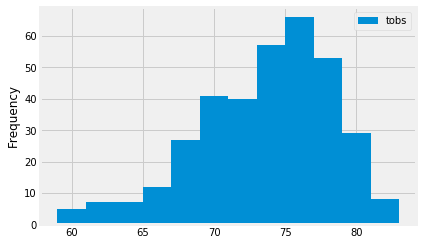

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
a_temp = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == f"{active_df['Station'][0]}").all()
#put temp in a_list and Create histogram
h_list = list(np.ravel(a_temp))
plt.hist(h_list, bins=12, histtype='bar', label='tobs')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-03-15', '2017-03-28'))

[(65.0, 73.18072289156626, 80.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-03-15', '2016-03-28'))

[(63.0, 70.69411764705882, 82.0)]


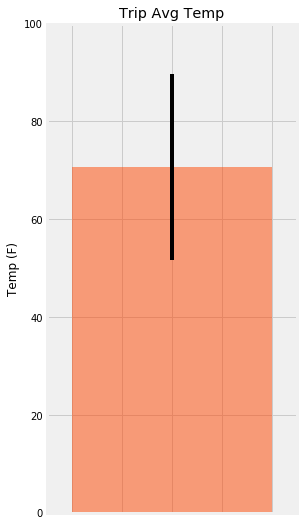

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip= calc_temps('2016-03-15', '2016-03-28')
my_trips = list(np.ravel(my_trip))
t_min = my_trips[0]
t_ave = my_trips[1]
t_max = my_trips[2]

#Plot avg temp with error bar
fig,ax = plt.subplots(figsize=(4,9))
plt.bar(0, height=t_ave, yerr= (t_max-t_min), color='orangered', alpha = .50)
ax.set_xticklabels([])
ax.yaxis.set_tick_params()
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0, 100)
plt.xlim(-.50,.50)
plt.show()

In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Measurement.prcp).\
    filter(Measurement.date.between('2016-03-15','2017-03-15')).\
    join(Station, Measurement.station==Station.station).\
    group_by(Measurement.station).\
    order_by(Measurement.prcp.desc()).all()

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 0.06),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 0.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  0.0),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 0.0),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  0.0)]

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = dt.date(2019, 5, 1)
end_date = dt.date(2019, 5, 6)
# Use the start and end date to create a range of dates
d_list=[]
d_diff = end_date - start_date
for i in range(d_diff.days + 1):
    d_list.append(start_date + dt.timedelta(i))
# Stip off the year and save a list of %m-%d strings
off_day = []
for ad in d_list:
    off_day.append(ad.strftime("%m" + "-" + "%d"))
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in off_day:
    normals.append(daily_normals(day))
    
normals

[[(65.0, 72.75925925925925, 79.0)],
 [(65.0, 73.05084745762711, 79.0)],
 [(67.0, 73.41071428571429, 84.0)],
 [(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Unravel normals list
normals = list(np.ravel(normals))

#break out tmin, tave, and tmax to assemble DF 
min_t = [normals[0], normals[3], normals[6], normals[9], normals[12], normals[15]]
ave_t = [normals[1], normals[4], normals[7], normals[10], normals[13], normals[16]]
max_t = [normals[2], normals[5], normals[8], normals[11], normals[14], normals[17]]
normals
#create dataframe 
trip_n = (pd.DataFrame({'Date': d_list,'Min Temp': min_t,'Avg Temp': ave_t,'Max Temp': max_t})).set_index("Date")
trip_n

,Min Temp,Avg Temp,Max Temp
Date,,,
2019-05-01,65.0,72.759259,79.0
2019-05-02,65.0,73.050847,79.0
2019-05-03,67.0,73.410714,84.0
2019-05-04,65.0,73.596491,78.0
2019-05-05,67.0,73.396552,79.0
2019-05-06,66.0,73.140351,80.0


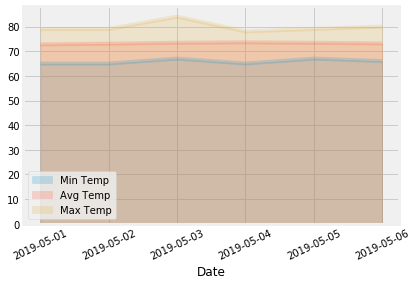

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_n.plot.area(stacked=False, alpha = .2)
plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=25)
plt.show()